## Linear Regression Implementation from Scratch

In [40]:
%matplotlib inline
from d2l import torch as d2l
import torch 

#### Step 1: Initializing the model
Before starting SGD, we need to initialize the model

In [41]:
class LinearRegressionScratch(d2l.Module):  #@save
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(mean=0, std=sigma, size=(num_inputs, 1), requires_grad=True)
        self.b = torch.tensor([0.], requires_grad=True)

In [42]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return X @ self.w + self.b

#### Step 2: Defining the loss function
We are using the mean squared loss

In [43]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

#### Step 3: Defining the optimization algorithm
we are using minibatch SGD. The following code applies the update, given a set of parameters, a learning rate lr

In [44]:
class SGD(d2l.HyperParameters):  #@save
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param += (-1) * param.grad * self.lr

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [45]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

#### Step 4: Training

In [46]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

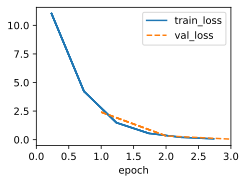

In [47]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

#### Exercise

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1000$ rather than $0.01$?
- When all weights are initialized to zero, every neuron in each layer will behave identically. This means they will all compute the same output and receive the same gradient during backpropagation
- Initializing weights with a very high variance can lead to a problem known as exploding gradients. This happens when the gradients during backpropagation become excessively large, causing very large updates to the weights and potentially leading to numerical instability. This makes the training process highly unstable and often divergent

## Concise Implementation of Linear Regression

In [72]:
import numpy as np
from torch import nn
from d2l import torch as d2l
import torch

#### Step 1: Defining the model
- In pytorch, a fully connected layer is defined as `Linear` and `LazyLinear` layers. In LazyLinear we do not have to define the number of input dimensions

In [64]:
class LinearRegression(d2l.Module):   #@save
    
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [65]:
@d2l.add_to_class(LinearRegression)   #@save
def forward(self, X):
    return self.net(X)

#### Step 2: Defining the loss function
- The MSELoss function computes the mean squared error loss (without the factor of 1/2 which we used earlier)

In [66]:
@d2l.add_to_class(LinearRegression)   #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

#### Step 3: Defining the Optimization Algorithm

In [67]:
@d2l.add_to_class(LinearRegression)   #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

#### Step 4: Training

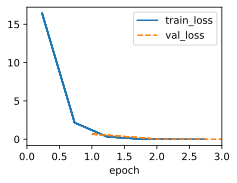

In [68]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

#### Exercise
2. Review the framework documentation to see which loss functions are provided. In particular,
   replace the squared loss with Huber's robust loss function. That is, use the loss function
   $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \textrm{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$


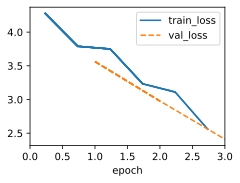

In [71]:
class LinearRegression(d2l.Module):   #@save    
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

@d2l.add_to_class(LinearRegression)   #@save
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)   #@save
def loss(self, y_hat, y):
    fn = nn.HuberLoss()
    return fn(y_hat, y)

@d2l.add_to_class(LinearRegression)   #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

3. How do you access the gradient of the weights of the model?

In [77]:
model.net.weight.grad

tensor([[-0.0359,  0.7330]])

4. What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?

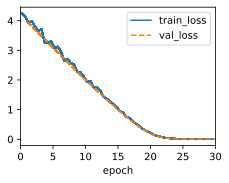

In [82]:
# lr = 0.01 and 30 epochs
model = LinearRegression(lr=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=30)
trainer.fit(model, data)

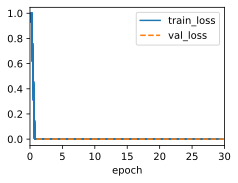

In [81]:
# lr = 0.01 and 30 epochs
model = LinearRegression(lr=1)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=30)
trainer.fit(model, data)

4. How does the solution change as you vary the amount of data generated?
    1. Plot the estimation error for $\hat{\mathbf{w}} - \mathbf{w}$ and $\hat{b} - b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, ..., 10,000 rather than 1000, 2000, ..., 10,000.
    2. Why is the suggestion in the hint appropriate?


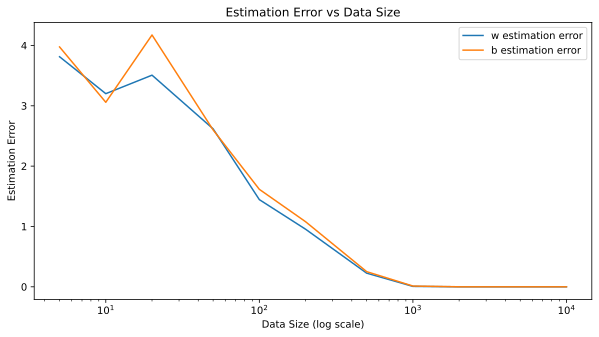

In [90]:
# Generated by GPT4
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Defining the LinearRegression model as provided
class LinearRegression(nn.Module):
    def __init__(self, lr):
        super(LinearRegression, self).__init__()
        self.lr = lr
        self.net = nn.LazyLinear(1)  # Assuming a 2D input for the synthetic data
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

# Function to create synthetic data
def create_synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# True parameters
true_w = torch.tensor([2, -3.4])
true_b = 4.2

# Training function
def train_model(data_size, lr=0.03, epochs=3):
    # Create dataset
    X, y = create_synthetic_data(true_w, true_b, data_size)
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Model
    model = LinearRegression(lr)
    optimizer = model.configure_optimizers()
    criterion = model.loss

    # Training loop
    for epoch in range(epochs):
        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()
            y_hat = model(X_batch)
            loss = criterion(y_hat, y_batch)
            loss.backward()
            optimizer.step()

    # Extracting trained parameters
    trained_w = model.net.weight.data
    trained_b = model.net.bias.data

    return trained_w, trained_b

# Sizes of datasets to train on
data_sizes = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

# Storing errors
w_errors = []
b_errors = []

# Training and calculating errors
for size in data_sizes:
    trained_w, trained_b = train_model(size)
    w_error = torch.norm(trained_w - true_w, p=2).item()
    b_error = abs(trained_b - true_b).item()
    w_errors.append(w_error)
    b_errors.append(b_error)

# Plotting the errors
plt.figure(figsize=(10, 5))
plt.plot(data_sizes, w_errors, label='w estimation error')
plt.plot(data_sizes, b_errors, label='b estimation error')
plt.xscale('log')
plt.xlabel('Data Size (log scale)')
plt.ylabel('Estimation Error')
plt.title('Estimation Error vs Data Size')
plt.legend()
plt.show()

## Generalization
- <b>Key Challenge in Machine Learning</b>: Differentiating between memorizing data and discovering generalizable patterns is a central challenge in machine learning, aimed at making accurate predictions for new, unseen data.
- <b>Finite Data and Overfitting Risk</b>: Models are built with limited data sets, varying in size across fields. This finite nature raises the risk of overfitting, where models perform well on training data but poorly on unseen data.
- <b>Regularization and Continuous Research</b>: Techniques known as regularization methods are used to combat overfitting. Understanding and improving model generalization is an ongoing area of research, combining theoretical principles and empirical methods.
- <b>Model Complexity and Data Abundance</b>: With simple models and ample data, training and generalization errors are typically similar. However, complex models or limited data often result in lower training errors but increased generalization gaps.
- <b>Limits of Model Expressiveness</b>: Extremely expressive models can perfectly fit any dataset, even with randomly assigned labels, but this perfect fit doesn't guarantee low generalization error. Such models might perform no better than random guessing on new data, as their ability to fit data doesn't necessarily indicate the discovery of a generalizable pattern.
- <b>The Role of Model Complexity and Falsifiability</b>: Inspired by Karl Popper's philosophy of science, model complexity should be such that the model doesn't fit arbitrary labels, implying it has identified a pattern. The notion of falsifiability suggests that a valid scientific theory should not be able to explain every possible observation.
- <b>Deep Neural Networks and Validation Error</b>: While deep neural networks can fit arbitrary labels and thus have low training errors, this doesn't ensure low generalization errors. Therefore, the use of holdout data (validation sets) is crucial for assessing the generalization capability of such models, as evidenced by the validation error.
- <b>Underfitting</b>: When both training and validation errors are high with a small gap between them, it suggests underfitting. This indicates the model is too simple and lacks the expressiveness to capture the underlying pattern in the data. In such cases, a more complex model might be necessary.
- <b>Overfitting in Deep Learning</b>: If the training error is significantly lower than the validation error, it indicates overfitting. However, in deep learning, overfitting is not always detrimental. The primary goal is to minimize the generalization error, and overfitting is only a concern if it hinders this objective. When training error is zero, the generalization gap directly equates to the generalization error, so reducing this gap is essential for improvement

![Optional Image Title](https://d2l.ai/_images/capacity-vs-error.svg)

- In machine learning, increasing the size of the training dataset typically reduces the generalization error and helps prevent overfitting. Consequently, for a given task and data distribution, it's beneficial to balance model complexity with the volume of available data. Deep learning models, in particular, often surpass simpler models like linear ones only when trained with sufficiently large datasets, a scenario made feasible in recent times due to the widespread availability of large digital data sources and storage solutions.









